In [1]:
%load_ext autotime

In [2]:
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import JSON, display, Markdown
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import CCDData, Cutout2D
from loguru import logger
from panoptes.utils.images import bayer
from panoptes.utils.images import fits as fits_utils
from panoptes.utils.serializers import from_json
from panoptes.utils.time import current_time

from panoptes.pipeline.scripts import image as image_processing
from panoptes.pipeline.utils import metadata
from panoptes.pipeline.utils.plot import plot_bg_overlay, plot_raw_bg_overlay, plot_stellar_location

logger.enable('panoptes')
sb.set_theme()

time: 1.87 s


In [3]:
current_time()

<Time object: scale='utc' format='datetime' value=2022-06-15 04:10:16.429102>

time: 5.41 ms


In [4]:
# Input parameters
fits_path = 'https://storage.googleapis.com/panoptes-images-raw/PAN023/548ef7/20220613T062756/20220613T070549.fits.fz'
output_dir = tempfile.TemporaryDirectory().name
force_new = True

# JSON string of additional settings.
image_settings = '{}'

time: 2.27 ms


In [5]:
# Parse the image settings.
image_settings = from_json(image_settings)

# Set up output directory and filenames.
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)

# Override output dir with provided.
image_settings['output_dir'] = output_dir

# Get the settings object.
settings = image_processing.Settings(**image_settings)

# Prepend the output dir to the file objects.
for file_type, file_name in settings.files:
    setattr(settings.files, file_type, output_dir / file_name)

time: 4.24 ms


In [6]:
image_uid = metadata.ObservationPathInfo(path=fits_path).get_full_id(sep='/')

time: 3.94 ms


In [7]:
Markdown(f'# Processing for {image_uid}')

# Processing for PAN023/548ef7/20220613T062756/20220613T070549

time: 6.39 ms


### Get data

In [8]:
raw_data, header = fits_utils.getdata(str(fits_path), header=True)

# Get the path info.
path_info = metadata.ObservationPathInfo.from_fits_header(header)
wcs0 = WCS(header)
wcs0

WCS Keywords

Number of WCS axes: 2
CTYPE : ''  ''  
CRVAL : 0.0  0.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 1.0  1.0  
NAXIS : 6020  4016

time: 818 ms


In [9]:
settings.params.camera.image_height = raw_data.shape[0]
settings.params.camera.image_width = raw_data.shape[1]

time: 588 µs


In [10]:
# settings.params.catalog.vmag_limits = (6, 14)

time: 1.71 ms


In [11]:
settings.params.background.box_size = (
    settings.params.camera.image_height / 251,
    settings.params.camera.image_width / 301,
)
settings.params.background.filter_size = (8, 10)

time: 646 µs


In [12]:
settings.params.dict()

{'camera': {'zero_bias': 2048.0,
  'saturation': 11530.0,
  'effective_gain': 1.5,
  'image_width': 6020,
  'image_height': 4016},
 'catalog': {'vmag_limits': (6, 13),
  'max_separation_arcsec': 25,
  'localbkg_width_pixels': 2,
  'detection_threshold': 10.0,
  'num_detect_pixels': 4,
  'catalog_filename': None},
 'background': {'box_size': (16.0, 20.0), 'filter_size': (8, 10)}}

time: 3.88 ms


### Mask bias and outliers

In [13]:
# Subtract zero bias.
data = CCDData(raw_data - settings.params.camera.zero_bias, wcs=wcs0, unit='adu')

time: 73.2 ms


In [14]:
data.mask = np.logical_or(
    data.data >= settings.params.camera.saturation,
    data.data <= 0
)

time: 67.7 ms


In [15]:
data.meta = settings.params.dict()

time: 581 µs


### Subtract RGB background

In [16]:
# Get RGB background data.
rgb_background = bayer.get_rgb_background(data=data.data,
                                          return_separate=True,
                                          box_size=settings.params.background.box_size,
                                          filter_size=settings.params.background.filter_size,
                                          )

time: 31.8 s


In [17]:
combined_bg_data = list()
combined_bg_residual_data = list()
bg_values = dict()
print('Backgrounds:')
for color, bg in zip(bayer.RGB, rgb_background):
    bg_median = bg.background_median #.astype('int')
    bg_median_rms = bg.background_rms_median #.astype('int')
    
    bg_values[color.name] = dict(median=bg_median, rms=bg_median_rms)
    
    print(f'{color.name:>10s}: median={bg_median:.03f} rms={bg_median_rms:.03f}')

    # Subtract median background (one int per color channel).
    # color_data = np.ma.array(np.ones_like(bg.background) * bg_median, mask=bg.mask)
    # color_residual_data = np.ma.array(np.ones_like(bg.background) * bg_median_rms, mask=bg.mask)

    # Subtract background.
    color_data = np.ma.array(data=bg.background, mask=bg.mask)
    color_residual_data = np.ma.array(data=bg.background_rms, mask=bg.mask)

    combined_bg_data.append(color_data)
    combined_bg_residual_data.append(color_residual_data)

Backgrounds:
       RED: median=190.488 rms=11.030
     GREEN: median=532.919 rms=16.996
      BLUE: median=464.100 rms=15.705
time: 12.5 s


In [18]:
# Combine the colors
bg_data = np.ma.array(combined_bg_data).filled(0).sum(0)
bg_residual_data = np.ma.array(combined_bg_residual_data).filled(0).sum(0)
reduced_data = data - bg_data

time: 2.45 s


In [19]:
# Save reduced data to file for plate solving.
hdul = fits.HDUList([fits.PrimaryHDU(reduced_data.data, header=header)])
hdul.writeto(str(settings.files.reduced_filename), overwrite=force_new)
print(f'Saved file to {str(settings.files.reduced_filename)}')

Saved file to /tmp/tmplghjjz0e/image.fits
time: 257 ms


### Plate solve

In [20]:
solve_opts = [
    '--continue',
    '--ra', str(header['RA-MNT']),
    '--dec', str(header['DEC-MNT']),
    '--scale-low', '14',
    '--scale-high', '16',
    '--radius', '20',
    '--guess-scale',
    '--cpulimit', '30',
    '--no-verify',
    '--crpix-center',
    '--temp-axy',
    '--index-xyls', 'none',
    '--solved', 'none',
    '--match', 'none',
    '--rdls', 'none',
    '--corr', 'none',
    '--downsample', '4',
    '--no-plots',
]

time: 982 µs


In [21]:
# !solve-field {' '.join(solve_opts)} {str(settings.files.reduced_filename.absolute())}

time: 14.1 ms


In [22]:
!ls -lh {str(settings.files.reduced_filename.parent)}

total 185M
-rw-r--r-- 1 jupyter jupyter 185M Jun 15 04:11 image.fits
time: 142 ms


In [23]:
# header0 = fits_utils.getheader(f'{str(settings.files.reduced_filename.parent)}/image.new')

# wcs0 = fits_utils.getwcs(f'{str(settings.files.reduced_filename.parent)}/image.new')
# wcs0

time: 803 µs


In [24]:
# Plate solve newly calibrated file.
wcs0 = image_processing.plate_solve(settings=settings, filename=settings.files.reduced_filename)
wcs0

Plate solving /tmp/tmplghjjz0e/image.fits
Solving completed successfully for /tmp/tmplghjjz0e/image.fits


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 211.767917019  54.4931760038  
CRPIX : 3010.5  2008.5  
CD1_1 CD1_2  : -0.00247666952042  -7.09350029494e-06  
CD2_1 CD2_2  : -6.9227639393e-06  0.00247734699015  
NAXIS : 6020  4016

time: 7.53 s


### Detect sources

In [25]:
# Detect sources with the reduced data
detected_sources = image_processing.detect_sources(wcs0, reduced_data, bg_data, bg_residual_data, settings=settings)

Detecting sources in image
De-blending image segments
Calculating total error for data using gain=1.5
Building source catalog for deblended_segments
time: 32.6 s


### Match detected sources to catalog

In [26]:
matched_sources = image_processing.match_sources(detected_sources, wcs0, settings=settings)

Matching 1503 sources to wcs.
Getting catalog sources from bigquery for WCS
Looking up catalog stars for WCS: [[223.08398981  48.99462254]
 [226.04854795  58.68152645]
 [197.44197698  58.63256068]
 [200.49581194  48.95933142]]
Searching square shape with round_to=0 and pad=1.0: {'ra_max': 232.0, 'ra_min': 192.0, 'dec_max': 64.0, 'dec_min': 44.0}
sql=
    SELECT id as picid, gaia as gaia, ra as catalog_ra, dec as catalog_dec, vmag as catalog_vmag, vmag_partition as catalog_vmag_bin, e_vmag as catalog_vmag_err, tmag as catalog_tmag, e_tmag as catalog_tmag_err, gaiamag as catalog_gaiamag, e_gaiamag as catalog_gaiamag_err, gaiabp as catalog_gaiabp_err, e_gaiabp as catalog_gaiabp, gaiarp as catalog_gaiarp_err, e_gaiarp as catalog_gaiarp, numcont as catalog_numcont, contratio as catalog_contratio 
    FROM catalog.pic
    WHERE
        (dec >= 44.0 AND dec <= 64.0) AND
        (ra >= 192.0 AND ra <= 232.0) AND
        (vmag_partition BETWEEN 6 AND 12)
    
Found 22083 in Vmag=[6, 13) and bou

### Filter matched sources

In [27]:
# matched_sources = matched_sources.query('photutils_fwhm <= 5 and catalog_contratio <= 200')

time: 376 µs


### Get metadata from image

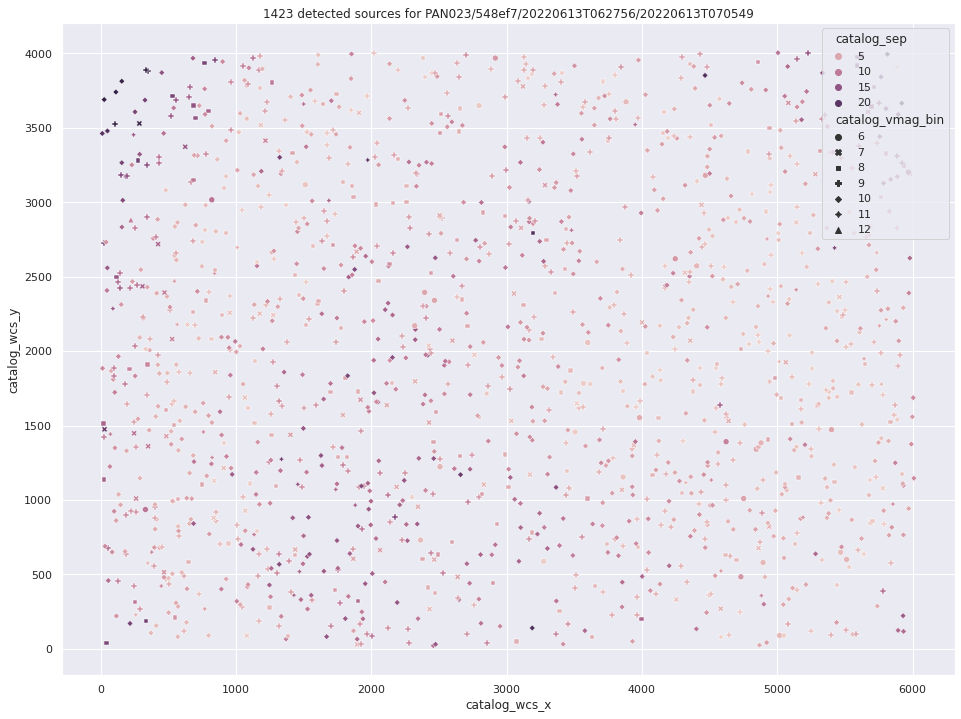

time: 595 ms


In [28]:
ax = sb.scatterplot(data=matched_sources, x='catalog_wcs_x', y='catalog_wcs_y', hue='catalog_sep', style='catalog_vmag_bin')
ax.figure.set_size_inches(16, 12)
ax.set_title(f'{len(matched_sources)} detected sources for {image_uid}');

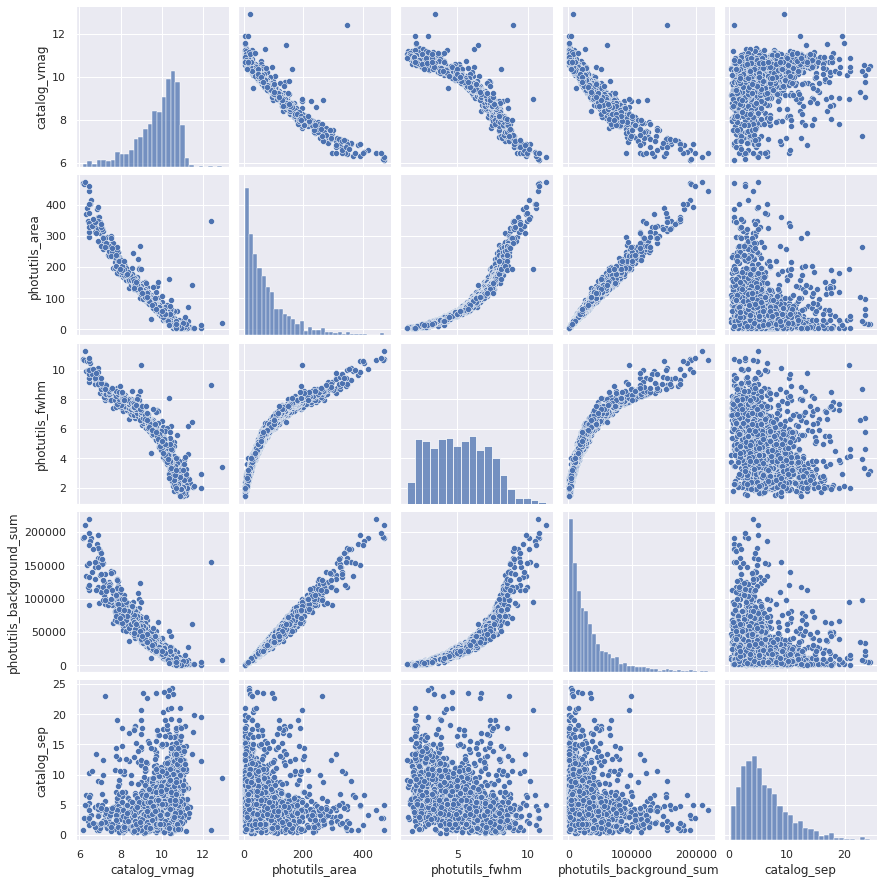

time: 4.77 s


In [29]:
sb.pairplot(matched_sources[['catalog_vmag', 'photutils_area', 'photutils_fwhm', 'photutils_background_sum', 'catalog_sep']])

In [30]:
metadata_headers = image_processing.get_metadata(header, matched_sources, settings=settings)

Total sources 1423
Removing bad FITS headers (comments, history)
Getting metadata from FITS headers
Saving metadata to json file /tmp/tmplghjjz0e/metadata.json
Saved metadata to /tmp/tmplghjjz0e/metadata.json.
time: 24.2 ms


In [31]:
# Write dataframe to csv.
matched_sources['time'] = pd.to_datetime(metadata_headers['image']['time'], utc=True)
matched_sources.set_index(['picid', 'time'], inplace=True)
matched_sources.to_parquet(settings.files.sources_filename)
print(f'Matched sources saved to {settings.files.sources_filename}')

Matched sources saved to /tmp/tmplghjjz0e/sources.parquet
time: 37.5 ms


In [32]:
if settings.compress_fits:
    print(f'Compressing FITS files')
    fits_utils.fpack(str(settings.files.reduced_filename), overwrite=force_new)
    # fits_utils.fpack(str(settings.files.extras_filename), overwrite=force_new)

Compressing FITS files
time: 1.55 s


## Plotting and visualizations

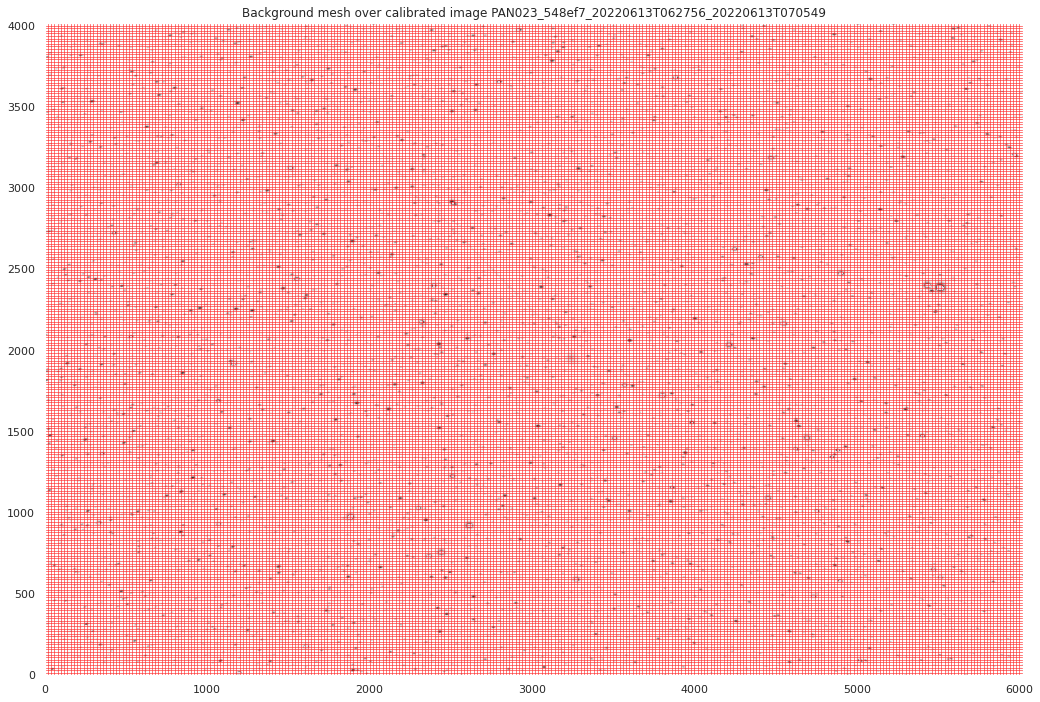

time: 1min 58s


In [33]:
plot_raw_bg_overlay(reduced_data, 
                    rgb_background=rgb_background[bayer.RGB.G], 
                    title=f'Background mesh over calibrated image {image_uid.replace("/", "_")}')

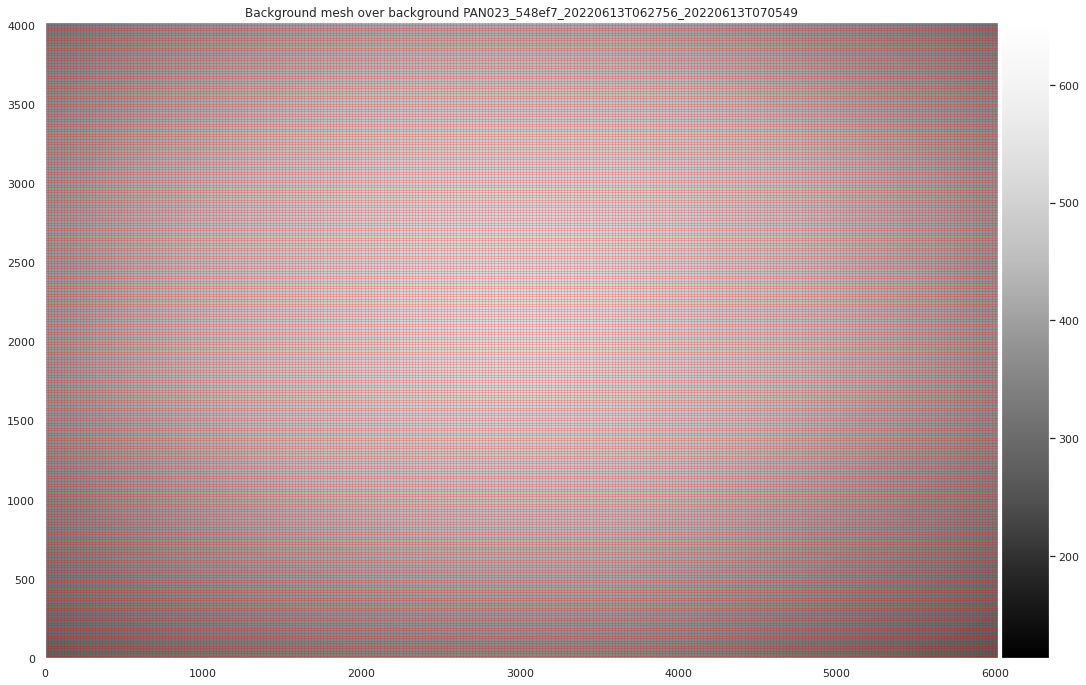

time: 2min


In [34]:
plot_bg_overlay(bg_data,
                rgb_background[bayer.RGB.G],
                title=f'Background mesh over background {image_uid.replace("/", "_")}')

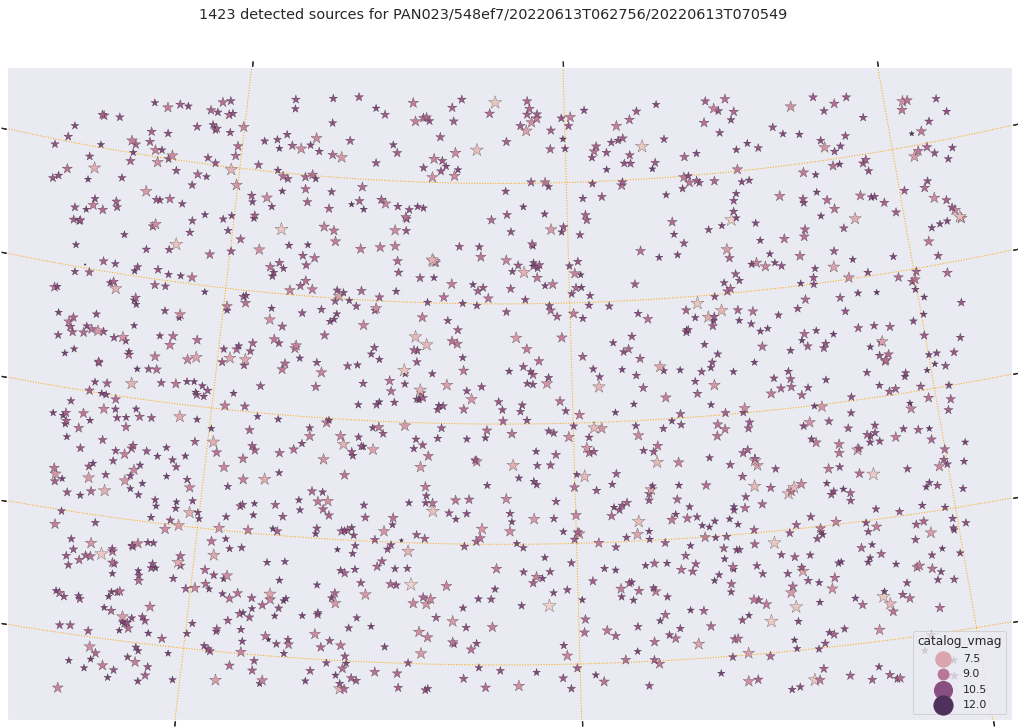

time: 620 ms


In [35]:
plot_stellar_location(matched_sources, 
                      wcs=wcs0, 
                      title=f'{len(matched_sources)} detected sources for {image_uid}')

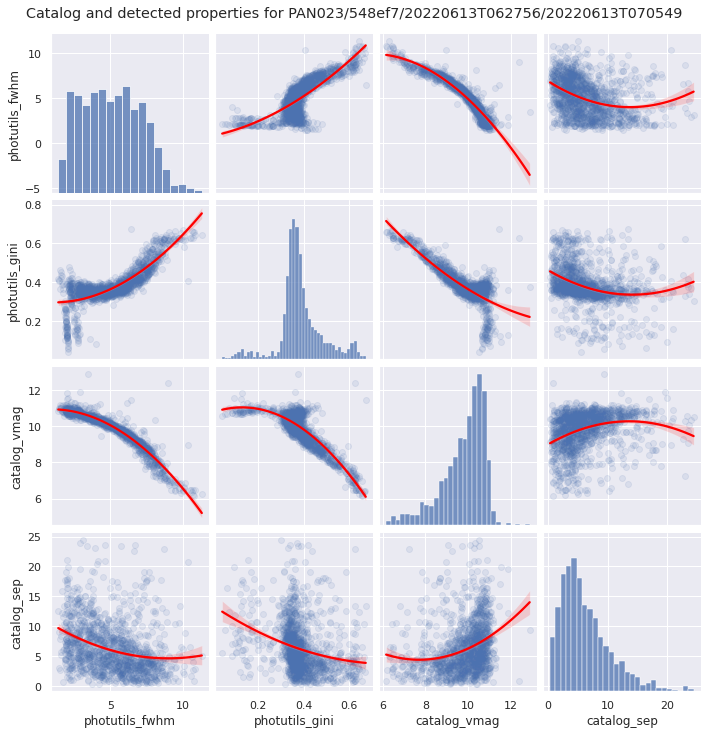

time: 7.36 s


In [36]:
dist_columns = [
    'photutils_fwhm',
    'photutils_gini',
    'catalog_vmag',
    'catalog_sep',
]

pg = sb.pairplot(matched_sources[dist_columns], kind='reg', plot_kws={'order': 2, 'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
pg.fig.suptitle(f'Catalog and detected properties for {image_uid}', y=1.02);

In [37]:
try:
    display(JSON(metadata_headers, expanded=True))
except Exception:
    from pprint import pprint
    pprint(metadata_headers)

<IPython.core.display.JSON object>

time: 4.99 ms


In [38]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.33.0
ipykernel        : 6.13.0
ipywidgets       : 7.7.0
jupyter_client   : 7.3.1
jupyter_core     : 4.10.0
jupyter_server   : 1.17.0
jupyterlab       : 3.2.9
nbclient         : 0.6.4
nbconvert        : 6.5.0
nbformat         : 5.4.0
notebook         : 6.4.11
qtconsole        : not installed
traitlets        : 5.2.2
time: 1.07 s


In [39]:
import json
print(json.dumps(from_json(settings.json()), indent=2))

{
  "params": {
    "camera": {
      "zero_bias": 2048.0,
      "saturation": 11530.0,
      "effective_gain": 1.5,
      "image_width": 6020,
      "image_height": 4016
    },
    "catalog": {
      "vmag_limits": [
        6,
        13
      ],
      "max_separation_arcsec": 25,
      "localbkg_width_pixels": 2,
      "detection_threshold": 10.0,
      "num_detect_pixels": 4,
      "catalog_filename": null
    },
    "background": {
      "box_size": [
        16.0,
        20.0
      ],
      "filter_size": [
        8,
        10
      ]
    }
  },
  "files": {
    "reduced_filename": "/tmp/tmplghjjz0e/image.fits",
    "extras_filename": "/tmp/tmplghjjz0e/extras.fits",
    "metadata_filename": "/tmp/tmplghjjz0e/metadata.json",
    "sources_filename": "/tmp/tmplghjjz0e/sources.parquet"
  },
  "compress_fits": true,
  "output_dir": "/tmp/tmplghjjz0e"
}
time: 2.39 ms


In [40]:
current_time()

<Time object: scale='utc' format='datetime' value=2022-06-15 04:16:05.652907>

time: 4.53 ms
